Install PyTorch and the PyTorch Geometric library

In [1]:
!pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
!pip install torch-geometric

Looking in indexes: https://download.pytorch.org/whl/cu118


Imports

In [35]:
import random
import numpy as np
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.multiclass import OneVsRestClassifier

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch_geometric.loader import DataLoader
from torch_geometric.datasets import Planetoid, TUDataset
from torch_geometric.explain import Explainer, GNNExplainer
from torch_geometric.utils import to_networkx, from_networkx, negative_sampling
from torch_geometric.nn import GCNConv, GINConv, global_mean_pool
from torch_geometric.transforms import NormalizeFeatures, RandomLinkSplit

Load the Cora Dataset and print some important features of it

In [3]:
dataset = Planetoid(root='data/Cora', name='Cora', transform=NormalizeFeatures())
data    = dataset[0]

print(f"Dataset: {dataset}")
print(f"Number of Classes: {dataset.num_classes}")
print(f"Number of Nodes: {data.num_nodes}")
print(f"Number of Edges: {data.num_edges}")
print(f"Node Features Shape: {data.x.shape}")
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

Dataset: Cora()
Number of Classes: 7
Number of Nodes: 2708
Number of Edges: 10556
Node Features Shape: torch.Size([2708, 1433])
Average node degree: 3.90
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Visualize the graph of the Cora Dataset

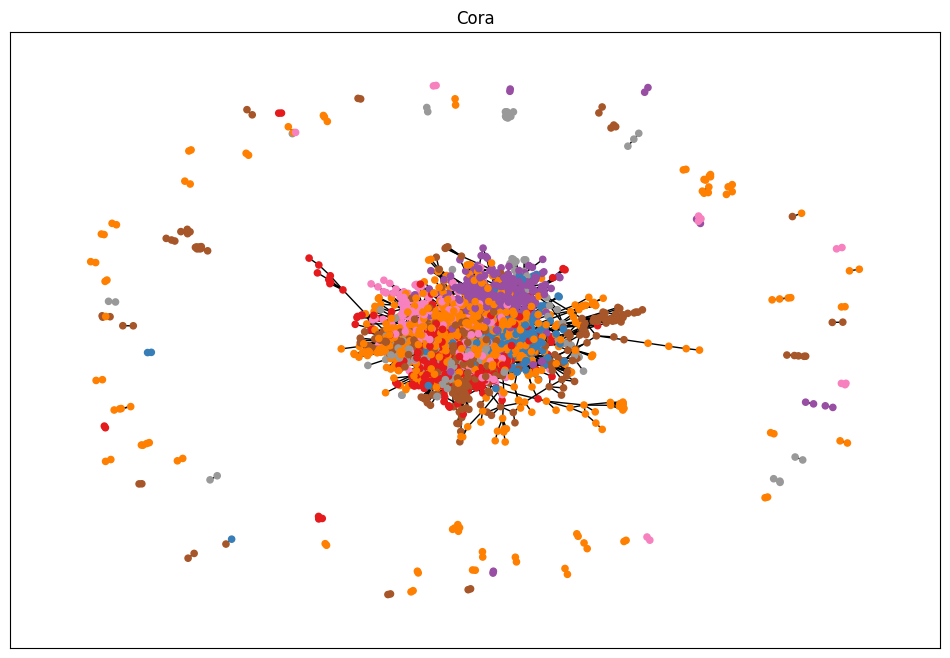

In [4]:
# Function to visualize a graph
def visualize_graph(data, title="Cora Dataset"):
    # Convert the graph data to a NetworkX graph and make it undirected
    G = to_networkx(data, node_attrs=['y'], to_undirected=True)

    plt.figure(figsize=(12, 8))

    # Extract the node labels from the graph
    labels = [G.nodes[n]['y'] for n in G.nodes()]

    cmap = plt.get_cmap('Set1')

    # Draw the graph using NetworkX's draw function
    nx.draw_networkx(
        G,
        node_color=labels,
        node_size=20,
        cmap=cmap,
        with_labels=False
    )

    plt.title(title)

    plt.show()

visualize_graph(data, title="Cora")

Find the Largest Connected Component of the dataset graph

In [5]:
# Convert the PyTorch Geometric graph to a NetworkX undirected graph
G = to_networkx(data, to_undirected=True)

# Iterate over each node in the graph to assign node features and labels
for i, node in enumerate(G.nodes()):
    G.nodes[node]['x'] = data.x[i].tolist()  # Convert node feature tensor to a list
    G.nodes[node]['y'] = data.y[i].item()    # Convert node label tensor to a scalar

# Find all connected components in the graph
connected_components = list(nx.connected_components(G))

# Find the largest connected component by length
largest_cc = max(connected_components, key=len)

# Create a subgraph that contains only the nodes and edges from the lcc
G_lcc = G.subgraph(largest_cc).copy()

print(f'LCC Data: {G_lcc.number_of_nodes()} nodes, {G_lcc.number_of_edges()} edges')

# Convert the subgraph of the largest connected component back to a PyTorch Geometric data object
data_lcc = from_networkx(G_lcc)

# convert the attribute x and y back to a tensor
if 'x' in data_lcc:
    data_lcc.x = torch.tensor([G_lcc.nodes[n]['x'] for n in G_lcc.nodes()], dtype=torch.float)

if 'y' in data_lcc:
    data_lcc.y = torch.tensor([G_lcc.nodes[n]['y'] for n in G_lcc.nodes()], dtype=torch.long)

print(f'Converted Back Data: {data_lcc.num_nodes} nodes, {data_lcc.num_edges} edges')


LCC Data: 2485 nodes, 5069 edges
Converted Back Data: 2485 nodes, 10138 edges


Splitting Graph Nodes into Train, Validation, and Test Sets

In [6]:
# Number of nodes in the largest connected component (LCC)
num_nodes = data_lcc.num_nodes

# Generate a list of indices representing the nodes in the graph
indices = list(range(num_nodes))

# Shuffle the indices randomly to ensure that the split is random
random.shuffle(indices)

# Define the split sizes for train, validation, and test sets (60, 20, 20)
train_size = int(0.6 * num_nodes)
val_size = int(0.2 * num_nodes)
test_size = num_nodes - train_size - val_size

# Split the indices into train, validation, and test sets
train_indices = indices[:train_size]
val_indices = indices[train_size:train_size + val_size]
test_indices = indices[train_size + val_size:]

# Initialize masks for each split
train_mask = torch.zeros(num_nodes, dtype=torch.bool)
val_mask = torch.zeros(num_nodes, dtype=torch.bool)
test_mask = torch.zeros(num_nodes, dtype=torch.bool)

# Set the corresponding indices to True for each mask
train_mask[train_indices] = True
val_mask[val_indices] = True
test_mask[test_indices] = True

# Assign the masks to the data object
data_lcc.train_mask = train_mask
data_lcc.val_mask = val_mask
data_lcc.test_mask = test_mask

print(f'Train Mask: {data_lcc.train_mask.sum()} nodes')
print(f'Validation Mask: {data_lcc.val_mask.sum()} nodes')
print(f'Test Mask: {data_lcc.test_mask.sum()} nodes')

Train Mask: 1491 nodes
Validation Mask: 497 nodes
Test Mask: 497 nodes


Graph Convolutional Network (GCN) Model Definition for Node Classification

In [7]:
class GCN(nn.Module):
    def __init__(self, num_features, hidden_dim, num_classes):
        super(GCN, self).__init__()

        # Define the first graph convolutional layer (conv1)
        # Takes the input features (num_features) and outputs a hidden dimension (hidden_dim)
        self.conv1 = GCNConv(num_features, hidden_dim)

        # Define the second graph convolutional layer (conv2)
        # Takes the hidden dimension (hidden_dim) and outputs the number of classes (num_classes)
        self.conv2 = GCNConv(hidden_dim, num_classes)

    def forward(self, x, edge_index):
        # Forward pass through the first graph convolutional layer
        x = self.conv1(x, edge_index)

        # Apply ReLU activation function to introduce non-linearity
        x = F.relu(x)

        # Apply dropout
        x = F.dropout(x, p=0.3, training=self.training)

        # Forward pass through the second graph convolutional layer
        x = self.conv2(x, edge_index)

        # Apply log softmax activation to the output
        return F.log_softmax(x, dim=1)


GCN Model Training and Evaluation for Node Classification

- Initialize the model: set up the GCN model, optimizer, and loss function
- Loop through the training function: training process, and update model parameters
- Evaluate metrics every 10 epochs: accuracy, precision, recall, and F1-score
- Final evaluation on the test set: after training, evaluate the model's performance on the test set

In [8]:
# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the GCN model and move it to the device
node_model = GCN(dataset.num_features, 16, dataset.num_classes).to(device)

# Move the data to the same device
data = data_lcc.to(device)

# Define the optimizer and the loss function
optimizer = torch.optim.Adam(node_model.parameters(), lr=0.01, weight_decay=1e-5)
criterion = torch.nn.CrossEntropyLoss()

# Training function
def train():
    node_model.train()
    optimizer.zero_grad()
    out = node_model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()
    return loss.item()

# Testing function
def test():
    node_model.eval()
    _, pred = node_model(data.x, data.edge_index).max(dim=1)
    true_labels = data.y[data.test_mask].cpu().numpy()
    pred_labels = pred[data.test_mask].cpu().numpy()

    accuracy = accuracy_score(true_labels, pred_labels)
    precision = precision_score(true_labels, pred_labels, average='weighted', zero_division=0)
    recall = recall_score(true_labels, pred_labels, average='weighted', zero_division=0)
    f1 = f1_score(true_labels, pred_labels, average='weighted')

    return accuracy, precision, recall, f1

# Function to plot confusion matrix
def plot_confusion_matrix():
    _, pred = node_model(data.x, data.edge_index).max(dim=1)

    true_labels = data.y[data.test_mask].cpu().numpy()
    pred_labels = pred[data.test_mask].cpu().numpy()

    ConfusionMatrixDisplay.from_predictions(true_labels, pred_labels)
    plt.show()


# Initialize lists to store loss and evaluation metrics for each epoch
loss_values = []
accuracy_values = []
precision_values = []
recall_values = []
f1_values = []

# Training loop
for epoch in range(200):
    loss = train()
    loss_values.append(loss)

    if epoch % 10 == 0:
        acc, precision, recall, f1 = test()

        accuracy_values.append(acc)
        precision_values.append(precision)
        recall_values.append(recall)
        f1_values.append(f1)

        print(f'Epoch {epoch}, Loss: {loss:.4f}, Test Accuracy: {acc:.4f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}')

# Final evaluation on the test set after training
test_acc, test_precision, test_recall, test_f1 = test()
print(f'Test Accuracy: {test_acc:.4f}, Test Precision: {test_precision:.4f}, Test Recall: {test_recall:.4f}, Test F1-score: {test_f1:.4f}')


Epoch 0, Loss: 1.9468, Test Accuracy: 0.3702, Precision: 0.3749, Recall: 0.3702, F1-score: 0.2602
Epoch 10, Loss: 1.8082, Test Accuracy: 0.3260, Precision: 0.4356, Recall: 0.3260, F1-score: 0.1781
Epoch 20, Loss: 1.6739, Test Accuracy: 0.3441, Precision: 0.5723, Recall: 0.3441, F1-score: 0.2123
Epoch 30, Loss: 1.4882, Test Accuracy: 0.5875, Precision: 0.6660, Recall: 0.5875, F1-score: 0.5385
Epoch 40, Loss: 1.2964, Test Accuracy: 0.7002, Precision: 0.6713, Recall: 0.7002, F1-score: 0.6585
Epoch 50, Loss: 1.0842, Test Accuracy: 0.7606, Precision: 0.7638, Recall: 0.7606, F1-score: 0.7238
Epoch 60, Loss: 0.9106, Test Accuracy: 0.8149, Precision: 0.7952, Recall: 0.8149, F1-score: 0.7951
Epoch 70, Loss: 0.7509, Test Accuracy: 0.8290, Precision: 0.8112, Recall: 0.8290, F1-score: 0.8124
Epoch 80, Loss: 0.6146, Test Accuracy: 0.8410, Precision: 0.8195, Recall: 0.8410, F1-score: 0.8252
Epoch 90, Loss: 0.5309, Test Accuracy: 0.8431, Precision: 0.8211, Recall: 0.8431, F1-score: 0.8276
Epoch 100, 

Visualization of Model Performance with Confusion Matrix and plots

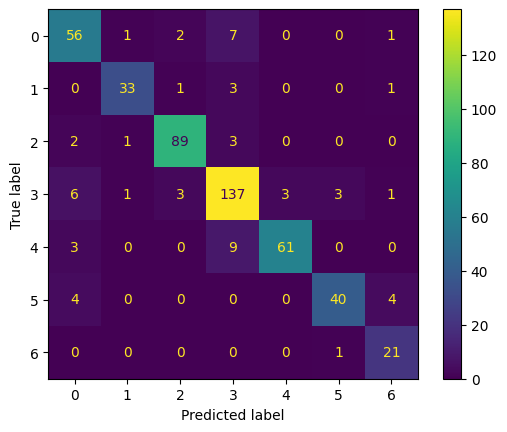

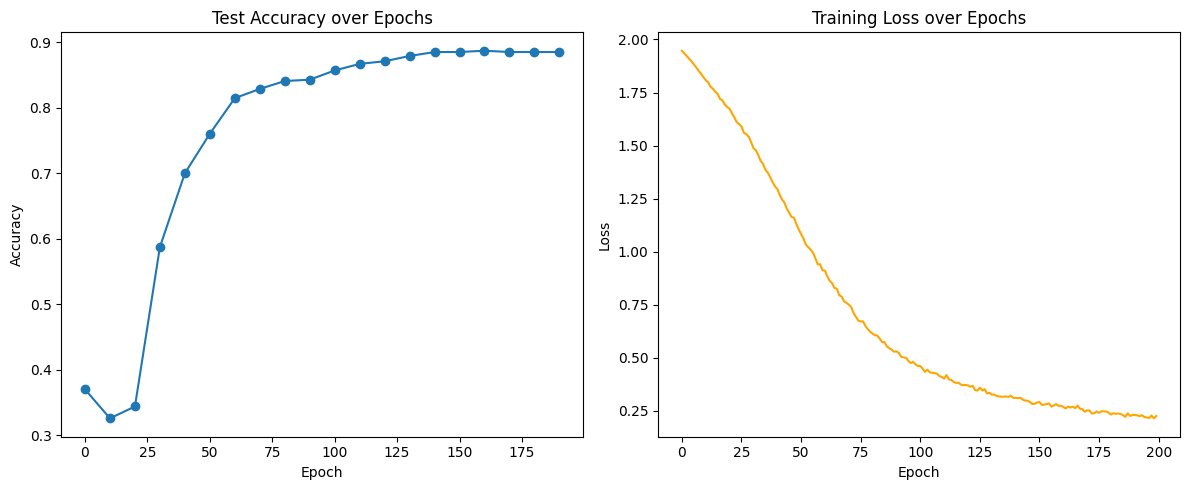

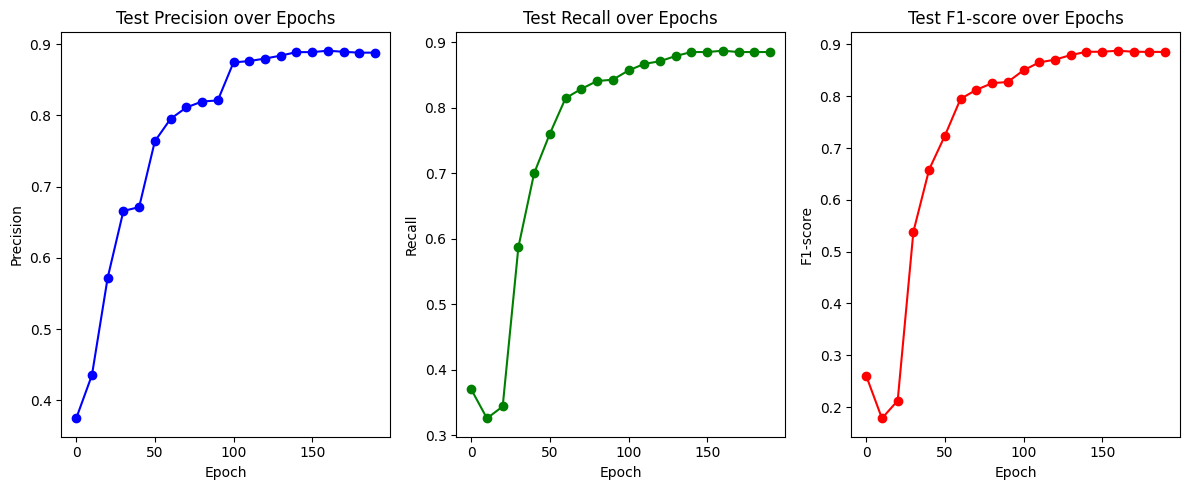

In [9]:
# Plot Confusion Matrix
plot_confusion_matrix()

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Plot Accuracy over Epochs
plt.subplot(1, 2, 1)
plt.plot(range(0, 200, 10), accuracy_values, marker='o')
plt.title('Test Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot Training Loss
plt.subplot(1, 2, 2)
plt.plot(range(200), loss_values, color='orange')
plt.title('Training Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.tight_layout()
plt.show()

plt.figure(figsize=(12, 5))

# Plot Precision over Epochs
plt.subplot(1, 3, 1)
plt.plot(range(0, 200, 10), precision_values, marker='o', color='blue')
plt.title('Test Precision over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Precision')

# Plot Recall over Epochs
plt.subplot(1, 3, 2)
plt.plot(range(0, 200, 10), recall_values, marker='o', color='green')
plt.title('Test Recall over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Recall')

# Plot F1-score over Epochs
plt.subplot(1, 3, 3)
plt.plot(range(0, 200, 10), f1_values, marker='o', color='red')
plt.title('Test F1-score over Epochs')
plt.xlabel('Epoch')
plt.ylabel('F1-score')

plt.tight_layout()
plt.show()


Save Node Classification Model

In [10]:
torch.save(node_model.state_dict(), 'node_classification_model.pth')
print("Model saved to node_classification_model.pth")

Model saved to node_classification_model.pth


Load CiteSeer and PubMed datased and print important features of them

In [11]:
citeSeer_dataset = Planetoid(root='data/CiteSeer', name='CiteSeer', transform=NormalizeFeatures())
pubMed_dataset = Planetoid(root='data/PubMed', name='PubMed', transform=NormalizeFeatures())

citeSeer_data = citeSeer_dataset[0]
pubMed_data = pubMed_dataset[0]

print(f"CiteSeer Dataset: {citeSeer_dataset}")
print(f"Number of Classes: {citeSeer_dataset.num_classes}")
print(f"Number of Nodes: {citeSeer_data.num_nodes}")
print(f"Number of Edges: {citeSeer_data.num_edges}")
print(f"Node Features Shape: {citeSeer_data.x.shape}")
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

print(f"\nPubMed Dataset: {pubMed_dataset}")
print(f"Number of Classes: {pubMed_dataset.num_classes}")
print(f"Number of Nodes: {pubMed_data.num_nodes}")
print(f"Number of Edges: {pubMed_data.num_edges}")
print(f"Node Features Shape: {pubMed_data.x.shape}")
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')

CiteSeer Dataset: CiteSeer()
Number of Classes: 6
Number of Nodes: 3327
Number of Edges: 9104
Node Features Shape: torch.Size([3327, 3703])
Average node degree: 4.08
Has isolated nodes: False
Has self-loops: False
Is undirected: True

PubMed Dataset: PubMed()
Number of Classes: 3
Number of Nodes: 19717
Number of Edges: 88648
Node Features Shape: torch.Size([19717, 500])
Average node degree: 4.08
Has isolated nodes: False
Has self-loops: False
Is undirected: True


Node Classification Model: Evaluation on different Datasets using saved weights

In [12]:
# Function to calculate metrics
def calculate_metrics(test_true, test_pred):
    # Compute accuracy, precision, recall, and F1-score using weighted averaging
    accuracy = accuracy_score(test_true.cpu(), test_pred.cpu())
    precision = precision_score(test_true.cpu(), test_pred.cpu(), average='weighted', zero_division=0)
    recall = recall_score(test_true.cpu(), test_pred.cpu(), average='weighted')
    f1 = f1_score(test_true.cpu(), test_pred.cpu(), average='weighted')

    return accuracy, precision, recall, f1

# Function to evaluate the model on a given dataset
def evaluate_model_on_dataset(model, data):
    model.eval()
    logits = model(data.x, data.edge_index)
    pred = logits.argmax(dim=1)

    # Extract predictions and true labels for the test set
    test_pred = pred[data.test_mask]
    test_true = data.y[data.test_mask]

    # Compute evaluation metrics
    accuracy, precision, recall, f1 = calculate_metrics(test_true, test_pred)

    return accuracy, precision, recall, f1

# Function to load a saved model and evaluate it on a dataset
def load_and_evaluate_model(dataset, data):
    # Initialize the GCN model with the dataset's feature and class dimensions
    model = GCN(dataset.num_features, 16, dataset.num_classes)

    # Load saved model weights trained on Cora dataset
    saved_model_weights = torch.load('node_classification_model.pth', weights_only=True)

    # Filter weights that match the current model's architecture
    model_dict = model.state_dict()
    saved_dict = {k: v for k, v in saved_model_weights.items() if k in model_dict and v.size() == model_dict[k].size()}

    # Update the model's weights with the loaded weights
    model_dict.update(saved_dict)
    model.load_state_dict(model_dict)

    # Move the model and data to the appropriate device
    model = model.to(device)
    data = data.to(device)

    # Evaluate the model on the given dataset
    return evaluate_model_on_dataset(model, data)

# Evaluation on CiteSeer dataset
citeSeer_accuracy, citeSeer_precision, citeSeer_recall, citeSeer_f1 = load_and_evaluate_model(citeSeer_dataset, citeSeer_data)
print("CiteSeer Metrics:")
print(f"Accuracy: {citeSeer_accuracy:.4f}")
print(f"Precision: {citeSeer_precision:.4f}")
print(f"Recall: {citeSeer_recall:.4f}")
print(f"F1-Score: {citeSeer_f1:.4f}")

# Evaluation on PubMed dataset
pubMed_accuracy, pubMed_precision, pubMed_recall, pubMed_f1 = load_and_evaluate_model(pubMed_dataset, pubMed_data)
print("\nPubMed Metrics:")
print(f"Accuracy: {pubMed_accuracy:.4f}")
print(f"Precision: {pubMed_precision:.4f}")
print(f"Recall: {pubMed_recall:.4f}")
print(f"F1-Score: {pubMed_f1:.4f}")


CiteSeer Metrics:
Accuracy: 0.1600
Precision: 0.0256
Recall: 0.1600
F1-Score: 0.0441

PubMed Metrics:
Accuracy: 0.4060
Precision: 0.1656
Recall: 0.4060
F1-Score: 0.2352


Link Prediction Task on Cora Dataset

- Generate negative edges equal to positive edges
- Split the dataset into train, validation and test

In [13]:
# Load the Cora dataset
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

# Function to generate negative edges
def generate_negative_edges(data, edge_index, num_neg_samples):
    num_nodes = data.num_nodes  # Get the number of nodes in the graph
    neg_edge_index = []  # Initialize a list to store negative edges

    while len(neg_edge_index) < num_neg_samples:  # Continue until we have the desired number of negative edges
        # Sample two random nodes
        u = random.randint(0, num_nodes - 1)
        v = random.randint(0, num_nodes - 1)

        # Ensure that the edge does not already exist (no self-loops and no existing positive edges), and in case add it to the list
        if u != v and not ((edge_index[0] == u) & (edge_index[1] == v)).any() and not ((edge_index[0] == v) & (edge_index[1] == u)).any():
            neg_edge_index.append([u, v])

    return torch.tensor(neg_edge_index).t().contiguous()


num_edges = data.edge_index.size(1)  # Get the total number of edges

# Define the sizes for each split
train_size = int(0.7 * num_edges)  # 70% of edges for training
val_size = int(0.1 * num_edges)  # 10% of edges for validation
test_size = num_edges - train_size - val_size  # Remaining 20% for testing

# Shuffle the edges randomly
perm = torch.randperm(num_edges)

# Split the edges into training, validation, and test sets
train_edge_index = data.edge_index[:, perm[:train_size]]  # First 70% for training
val_edge_index = data.edge_index[:, perm[train_size:train_size + val_size]]  # Next 10% for validation
test_edge_index = data.edge_index[:, perm[train_size + val_size:]]  # Remaining 20% for testing

# Generate negative edges for the training, validation, and test sets
train_neg_edge_index = generate_negative_edges(data, train_edge_index, train_size)  # Negative edges for training
val_neg_edge_index = generate_negative_edges(data, val_edge_index, val_size)  # Negative edges for validation
test_neg_edge_index = generate_negative_edges(data, test_edge_index, test_size)  # Negative edges for testing

# Print the number of positive and negative edges for each set
print(f"Number of positive edges in the training set: {train_edge_index.size(1)}")
print(f"Number of negative edges in the training set: {train_neg_edge_index.size(1)}")
print(f"Number of positive edges in the validation set: {val_edge_index.size(1)}")
print(f"Number of negative edges in the validation set: {val_neg_edge_index.size(1)}")
print(f"Number of positive edges in the test set: {test_edge_index.size(1)}")
print(f"Number of negative edges in the test set: {test_neg_edge_index.size(1)}")


Number of positive edges in the training set: 7389
Number of negative edges in the training set: 7389
Number of positive edges in the validation set: 1055
Number of negative edges in the validation set: 1055
Number of positive edges in the test set: 2112
Number of negative edges in the test set: 2112


Model definition: Graph Convolutional Network (GCN) for Link Prediction

In [14]:
class GCNLinkPrediction(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, dropout=0.3):
        super(GCNLinkPrediction, self).__init__()

        # First Graph Convolutional Layer
        self.conv1 = GCNConv(in_channels, hidden_channels)
        # Second Graph Convolutional Layer
        self.conv2 = GCNConv(hidden_channels, out_channels)
        # Batch Normalization for the hidden layer
        self.batch_norm1 = torch.nn.BatchNorm1d(hidden_channels)
        # Batch Normalization for the output layer
        self.batch_norm2 = torch.nn.BatchNorm1d(out_channels)
        # Dropout rate
        self.dropout = dropout

        # Decoder MLP to predict link scores
        self.mlp_decoder = torch.nn.Sequential(
            torch.nn.Linear(2 * out_channels, out_channels),  # First fully connected layer (concatenate node embeddings)
            torch.nn.ReLU(),  # ReLU activation function
            torch.nn.Linear(out_channels, 1)  # Output layer to predict the link score
        )

    def encode(self, x, edge_index):
        # Perform graph convolution, apply ReLU activation, batch normalization, and dropout for regularization
        x = F.relu(self.batch_norm1(self.conv1(x, edge_index)))
        x = F.dropout(x, p=self.dropout, training=self.training)
        x = self.batch_norm2(self.conv2(x, edge_index))

        # Return the node embeddings
        return x

    def decode(self, z, edge_index):
        # Concatenate the embeddings of the two nodes for each edge
        z1 = z[edge_index[0]]
        z2 = z[edge_index[1]]
        edge_features = torch.cat([z1, z2], dim=-1)

        # Return the predicted link score (squeezed to remove extra dimension)
        return self.mlp_decoder(edge_features).squeeze(-1)


Training and Evaluation of GCN for Link Prediction

The model is trained to predict whether an edge exists between two nodes in a graph, based on their embeddings:

- Training function definition
- Evaluation function definition
- Training of the model
- Evaluation of the model
- Metrics

In [15]:
def link_train(model, optimizer, data, train_pos_edges, train_neg_edges, device):
    model.train()
    optimizer.zero_grad()

    # Get the node embeddings from the model
    z = model.encode(data.x.to(device), data.edge_index.to(device))

    # Compute the scores for positive and negative edges
    pos_scores = model.decode(z, train_pos_edges)
    neg_scores = model.decode(z, train_neg_edges)

    # Create labels for positive (1) and negative (0) edges
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).to(device)

    # Concatenate the scores of positive and negative edges and compute the loss
    scores = torch.cat([pos_scores, neg_scores])
    loss = F.binary_cross_entropy_with_logits(scores, labels)

    # Backpropagation to compute gradients and update model parameters
    loss.backward()
    optimizer.step()

    return loss.item()

@torch.no_grad()
def link_evaluate(model, data, pos_edges, neg_edges, device):
    model.eval()

    # Get the node embeddings from the model
    z = model.encode(data.x.to(device), data.edge_index.to(device))

    # Compute the scores for positive and negative edges
    pos_scores = model.decode(z, pos_edges).sigmoid()
    neg_scores = model.decode(z, neg_edges).sigmoid()

    # Create labels for positive (1) and negative (0) edges
    labels = torch.cat([torch.ones(pos_scores.size(0)), torch.zeros(neg_scores.size(0))]).cpu().numpy()
    scores = torch.cat([pos_scores, neg_scores]).cpu().numpy()

    # Compute evaluation metrics
    predictions = (scores > 0.5).astype(int)
    accuracy = accuracy_score(labels, predictions)
    precision = precision_score(labels, predictions)
    recall = recall_score(labels, predictions)
    f1 = f1_score(labels, predictions)
    roc_auc = roc_auc_score(labels, scores)

    return accuracy, precision, recall, f1, roc_auc


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
link_model = GCNLinkPrediction(dataset.num_features, 128, 64).to(device)
optimizer = torch.optim.Adam(link_model.parameters(), lr=0.01, weight_decay=1e-4)

# Training loop
for epoch in range(200):

    loss = link_train(link_model, optimizer, data, train_edge_index, train_neg_edge_index, device)

    if epoch % 10 == 0:
        accuracy, precision, recall, f1, roc_auc = link_evaluate(
            link_model, data, val_edge_index, val_neg_edge_index, device
        )
        print(f'Epoch {epoch}, Loss: {loss:.4f}, Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
              f'Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')

# Final evaluation on the test set
accuracy, precision, recall, f1, roc_auc = link_evaluate(
    link_model, data,
    test_edge_index, test_neg_edge_index, device
)
print(f'Test Results - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
      f'Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')


Epoch 0, Loss: 0.7064, Accuracy: 0.5000, Precision: 0.5000, Recall: 1.0000, F1: 0.6667, ROC-AUC: 0.7122
Epoch 10, Loss: 0.2084, Accuracy: 0.5559, Precision: 0.9836, Recall: 0.1137, F1: 0.2039, ROC-AUC: 0.9505
Epoch 20, Loss: 0.0688, Accuracy: 0.8417, Precision: 0.9688, Recall: 0.7062, F1: 0.8169, ROC-AUC: 0.9735
Epoch 30, Loss: 0.0211, Accuracy: 0.9308, Precision: 0.9341, Recall: 0.9270, F1: 0.9305, ROC-AUC: 0.9808
Epoch 40, Loss: 0.0098, Accuracy: 0.9336, Precision: 0.9118, Recall: 0.9602, F1: 0.9354, ROC-AUC: 0.9805
Epoch 50, Loss: 0.0042, Accuracy: 0.9403, Precision: 0.9211, Recall: 0.9630, F1: 0.9416, ROC-AUC: 0.9807
Epoch 60, Loss: 0.0047, Accuracy: 0.9389, Precision: 0.9201, Recall: 0.9611, F1: 0.9402, ROC-AUC: 0.9809
Epoch 70, Loss: 0.0038, Accuracy: 0.9436, Precision: 0.9278, Recall: 0.9621, F1: 0.9446, ROC-AUC: 0.9835
Epoch 80, Loss: 0.0040, Accuracy: 0.9370, Precision: 0.9168, Recall: 0.9611, F1: 0.9385, ROC-AUC: 0.9818
Epoch 90, Loss: 0.0044, Accuracy: 0.9408, Precision: 0.9

ROC Curve Plotting for Link Prediction Model

Test Results - Accuracy: 0.9576, Precision: 0.9448, Recall: 0.9721, F1: 0.9582, ROC-AUC: 0.9891


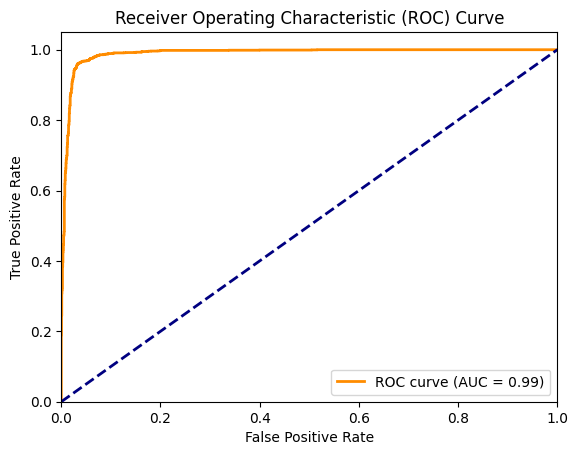

In [16]:
def plot_roc_curve(labels, scores):
    # Calculate the ROC curve
    fpr, tpr, thresholds = roc_curve(labels, scores)
    roc_auc = auc(fpr, tpr)

    # Plot ROC curve
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend(loc='lower right')
    plt.show()

accuracy, precision, recall, f1, roc_auc = link_evaluate(
    link_model, data,
    test_edge_index, test_neg_edge_index, device
)
print(f'Test Results - Accuracy: {accuracy:.4f}, Precision: {precision:.4f}, '
      f'Recall: {recall:.4f}, F1: {f1:.4f}, ROC-AUC: {roc_auc:.4f}')

# Calculate embeddings for the test data
z = link_model.encode(data.x.to(device), data.edge_index.to(device))

# Calculate the scores for positive and negative edges in the test set
pos_scores = link_model.decode(z, test_edge_index).sigmoid().detach().cpu().numpy()
neg_scores = link_model.decode(z, test_neg_edge_index).sigmoid().detach().cpu().numpy()

# True labels: 1 for positive edges, 0 for negative edges
labels = np.concatenate([np.ones(pos_scores.shape[0]), np.zeros(neg_scores.shape[0])])

# Concatenate the predicted scores for positive and negative edges
scores = np.concatenate([pos_scores, neg_scores])

# Plot the ROC curve
plot_roc_curve(labels, scores)


Save

Save Link Prediction Model

In [17]:
torch.save(link_model.state_dict(), 'link_prediction_model.pth')
print("Model saved to gcn_model.pth")

Model saved to gcn_model.pth


Visualization of node embeddings of Node Classification Task

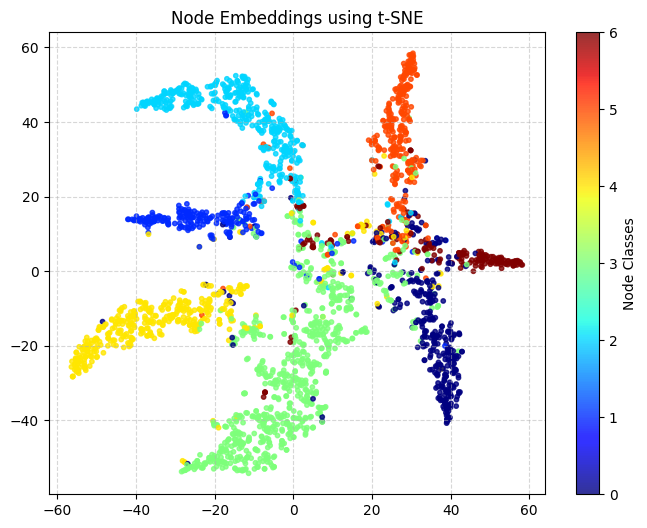

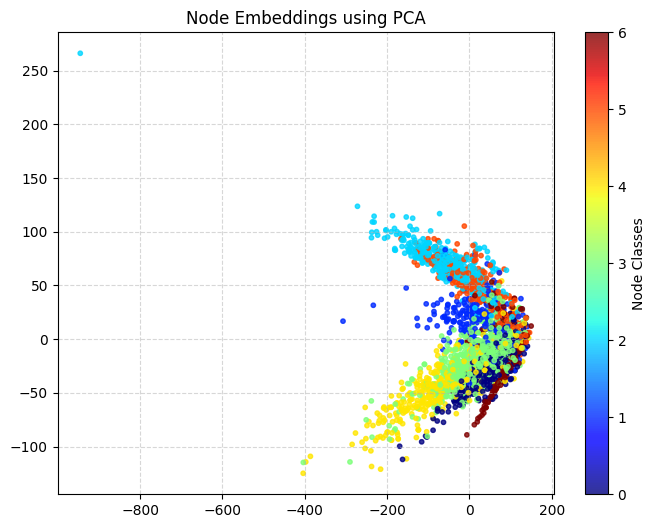

In [18]:
# Function to extract node embeddings and apply dimensionality reduction for visualization
def visualize_node_embeddings(model, data, method='PCA', n_components=2):
    model.eval()
    with torch.no_grad():  # Disable gradient computation as we're not training
        # Get node embeddings from the second GCN layer
        node_embeddings = model(data.x, data.edge_index)

        # Apply dimensionality reduction method (PCA or t-SNE)
        if method == 'PCA':
            reducer = PCA(n_components=n_components)
        elif method == 't-SNE':
            reducer = TSNE(n_components=n_components, perplexity=30, max_iter=1000)  # Initialize t-SNE

        # Reduce dimensions to 2D for visualization
        reduced_embeddings = reducer.fit_transform(node_embeddings.cpu().detach().numpy())

        # Visualize the embeddings in 2D
        plt.figure(figsize=(8, 6))
        scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=data.y.cpu().detach().numpy(), cmap='jet', s=10, alpha=0.8)
        plt.colorbar(scatter, label='Node Classes')
        plt.title(f"Node Embeddings using {method}")
        plt.grid(True, linestyle='--', alpha=0.5)
        plt.show()

# Visualize node embeddings using t-SNE
visualize_node_embeddings(node_model, data.to(device), method='t-SNE')
# Visualize node embeddings using PCA
visualize_node_embeddings(node_model, data.to(device), method='PCA')


Install Node2Vec

In [19]:
pip install node2vec

Node2Vec Embedding Generation for the Cora Dataset

In [20]:
# Import the necessary library for Node2Vec
from node2vec import Node2Vec

dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0].to(device)

# Convert the edge_index to a NumPy array for compatibility with NetworkX
edge_index = data.edge_index.cpu().numpy()

# Create an undirected graph from the edge_index
G = nx.from_edgelist(edge_index.T)

# Initialize the Node2Vec model with specified hyperparameters
# 'dimensions' sets the size of the node embeddings
# 'walk_length' is the length of each random walk
# 'num_walks' is the number of random walks per node
# 'workers' specifies the number of CPU cores to use for parallelization
node2vec = Node2Vec(G, dimensions=128, walk_length=30, num_walks=100, workers=4)

# Train the Node2Vec model with the given window size and batch settings
# 'window' specifies the maximum distance between the current and predicted nodes in the context
# 'min_count' sets the minimum number of occurrences for a word to be considered
# 'batch_words' is the number of words to process in each batch
model_node2vec = node2vec.fit(window=10, min_count=1, batch_words=4)

# Extract the node embeddings after training the Node2Vec model
node2vec_embeddings = model_node2vec.wv.vectors


Computing transition probabilities:   0%|          | 0/2708 [00:00<?, ?it/s]

Node Classification Using Node2Vec Embeddings and Logistic Regression

Evaluation Metrics on the model


In [21]:
# Use the precomputed Node2Vec embeddings with shape: [num_nodes, embedding_dim]
node2vec_data = node2vec_embeddings

# Extract the node labels from the dataset
# 'data.y' contains the node labels for classification
y = data.y.cpu().numpy()

# Split the data into training and test sets using the provided train and test masks
train_mask = data.train_mask.cpu().numpy()  # Extract the training mask
test_mask = data.test_mask.cpu().numpy()    # Extract the test mask

# Select the training and test data based on the masks
X_train = node2vec_data[train_mask]  # Select the training node embeddings
y_train = y[train_mask]             # Select the training labels
X_test = node2vec_data[test_mask]   # Select the test node embeddings
y_test = y[test_mask]               # Select the test labels

# Initialize the Logistic Regression classifier
# 'max_iter' is the maximum number of iterations for the solver
# 'multi_class' specifies the strategy for multi-class classification
# 'solver' specifies the optimization algorithm used by Logistic Regression
clf = LogisticRegressionCV(max_iter=2000, solver='lbfgs', cv=5)

# Train the classifier using the training data
clf.fit(X_train, y_train)

# Make predictions on the test set
y_pred = clf.predict(X_test)

# Evaluate the model's performance on the test set
test_acc = accuracy_score(y_test, y_pred)
test_precision = precision_score(y_test, y_pred, average='weighted')
test_recall = recall_score(y_test, y_pred, average='weighted')
test_f1 = f1_score(y_test, y_pred, average='weighted')

# Print the evaluation metrics
print(f'Test Accuracy: {test_acc:.4f}')
print(f'Test Precision: {test_precision:.4f}')
print(f'Test Recall: {test_recall:.4f}')
print(f'Test F1-score: {test_f1:.4f}')


Test Accuracy: 0.1480
Test Precision: 0.1867
Test Recall: 0.1480
Test F1-score: 0.1560


Visualizing Node2Vec Embeddings with Dimensionality Reduction, PCA or t-SNE

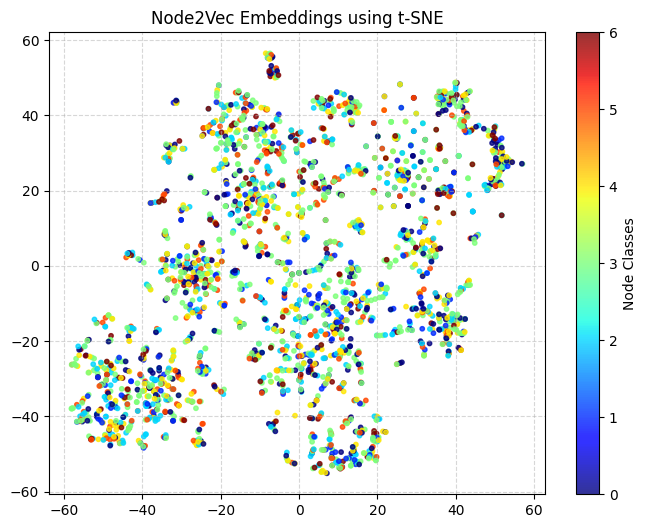

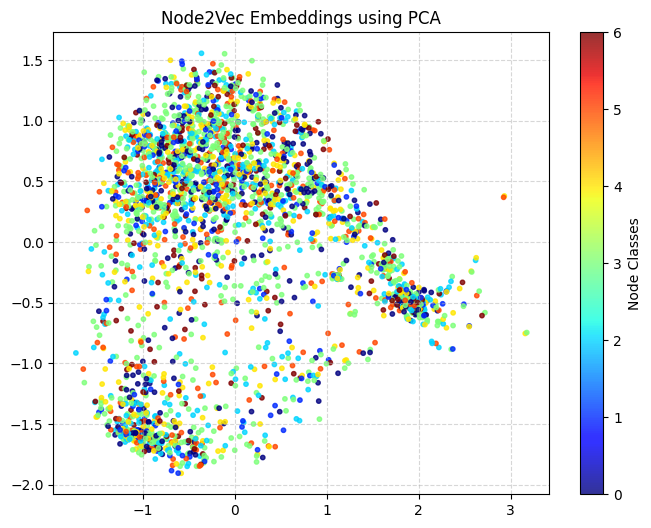

In [22]:
def visualize_node2vec_embeddings(node2vec_embeddings, labels, method, n_components=2):
    # Dimensionality reduction PCA or t-SNE
    if method == 'PCA':
        reducer = PCA(n_components=n_components)
    elif method == 't-SNE':
        reducer = TSNE(n_components=n_components, perplexity=50, max_iter=2000)

    # Reduce the embeddings to 2D for visualization
    reduced_embeddings = reducer.fit_transform(node2vec_embeddings)

    # Plot the reduced embeddings in 2D space
    plt.figure(figsize=(8, 6))
    scatter = plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=labels, cmap='jet', s=10, alpha=0.8)
    plt.colorbar(scatter, label='Node Classes')
    plt.title(f"Node2Vec Embeddings using {method}")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.show()

# Visualize the Node2Vec embeddings using t-SNE
visualize_node2vec_embeddings(node2vec_embeddings, data.y.cpu().detach().numpy(), method='t-SNE')
# Visualize the Node2Vec embeddings using PCA
visualize_node2vec_embeddings(node2vec_embeddings, data.y.cpu().detach().numpy(), method='PCA')


 Node Embedding Generation using Node2Vec for Link Prediction

In [23]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]

edge_index = data.edge_index.cpu().numpy()

# Shuffle edges to ensure random split
np.random.shuffle(edge_index.T)

# Split the edges into train and test sets (80% train, 20% test)
num_edges = edge_index.shape[1]
train_size = int(num_edges * 0.8)
test_size = num_edges - train_size  # Remaining 20% for test

train_edges = edge_index[:, :train_size]
test_edges = edge_index[:, train_size:]

# Generate negative samples for the training and test sets
def generate_negative_samples(edge_index, num_nodes, num_samples):
    all_edges = set(map(tuple, edge_index.T))
    negative_samples = []

    while len(negative_samples) < num_samples:
        u = np.random.randint(0, num_nodes)
        v = np.random.randint(0, num_nodes)
        if u != v and (u, v) not in all_edges and (v, u) not in all_edges:
            negative_samples.append([u, v])

    return np.array(negative_samples).T

num_nodes = data.num_nodes

# Generate negative edges for training and test
train_neg_edges = generate_negative_samples(train_edges, num_nodes, train_edges.shape[1])
test_neg_edges = generate_negative_samples(test_edges, num_nodes, test_edges.shape[1])

# Create the graph for Node2Vec
G = nx.Graph()
G.add_edges_from(train_edges.T)

# Run Node2Vec to obtain node embeddings
node2vec = Node2Vec(G, dimensions=128, walk_length=50, num_walks=100, workers=4)
model = node2vec.fit(window=10, min_count=1, batch_words=4)

# Collect node embeddings
node_embeddings = []
for i in range(data.num_nodes):
    node_str = str(i)
    if node_str in model.wv:
        node_embeddings.append(model.wv[node_str])
    else:
        node_embeddings.append(np.zeros(model.vector_size))

# Convert the list of embeddings to a numpy array
node_embeddings = np.array(node_embeddings)


Computing transition probabilities:   0%|          | 0/2681 [00:00<?, ?it/s]

Creating Node Pairs for Link Prediction and Training a Logistic Regression Model

In [24]:
def create_pairs(pos_edges, neg_edges, node_embeddings):
    pairs = []  # List to store the feature pairs
    labels = []  # List to store the labels (1 for positive, 0 for negative)

    # Positive pairs
    for edge in pos_edges.T:
        u, v = edge
        feature = np.concatenate([node_embeddings[u], node_embeddings[v]], axis=0)
        pairs.append(feature)
        labels.append(1)

    # Negative pairs
    for edge in neg_edges.T:
        u, v = edge
        feature = np.concatenate([node_embeddings[u], node_embeddings[v]], axis=0)
        pairs.append(feature)
        labels.append(0)

    return np.array(pairs), np.array(labels)

# Create feature pairs and labels for training and testing
train_pairs, train_labels = create_pairs(train_edges, train_neg_edges, node_embeddings)
test_pairs, test_labels = create_pairs(test_edges, test_neg_edges, node_embeddings)

# Train a logistic regression model for link prediction
clf = LogisticRegression(max_iter=1000)
clf.fit(train_pairs, train_labels)

# Make predictions on the test set
test_preds = clf.predict(test_pairs)

# Calculate evaluation metrics
test_accuracy = accuracy_score(test_labels, test_preds)
test_precision = precision_score(test_labels, test_preds)
test_recall = recall_score(test_labels, test_preds)
test_f1 = f1_score(test_labels, test_preds)
test_roc_auc = roc_auc_score(test_labels, test_preds)

# Print the evaluation metrics
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Precision: {test_precision:.4f}")
print(f"Test Recall: {test_recall:.4f}")
print(f"Test F1-score: {test_f1:.4f}")
print(f"Test ROC-AUC: {test_roc_auc:.4f}")

Test Accuracy: 0.5784
Test Precision: 0.5668
Test Recall: 0.6652
Test F1-score: 0.6121
Test ROC-AUC: 0.5784


Visualizing Important Edges with GNNExplainer for Node Classification

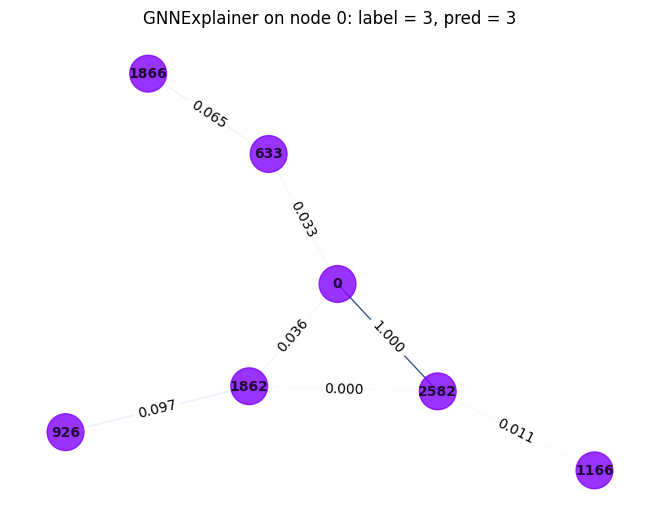

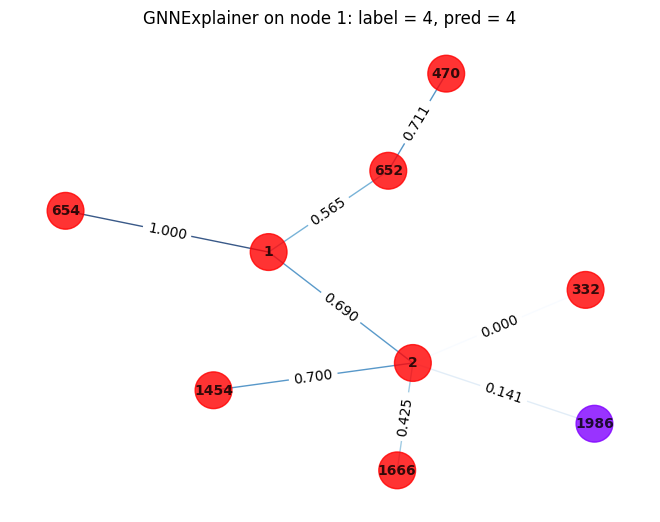

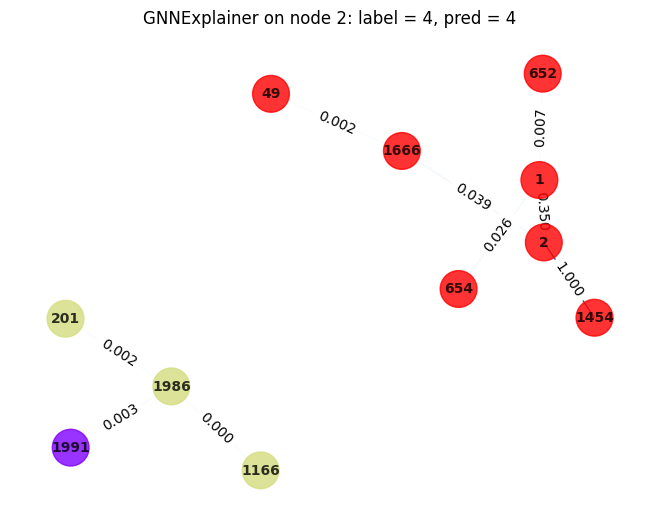

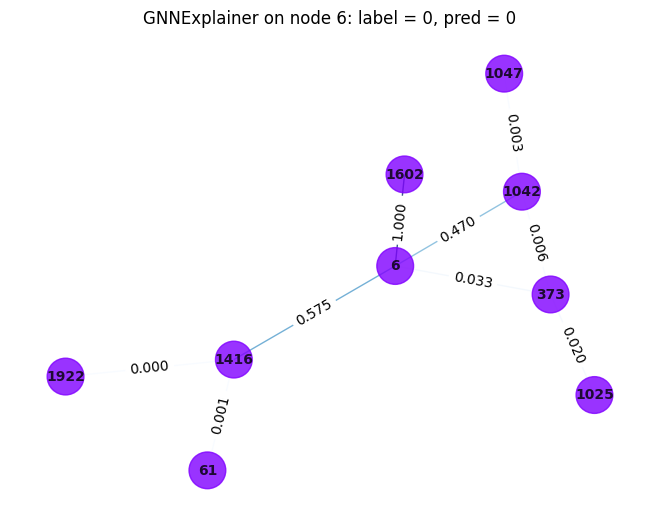

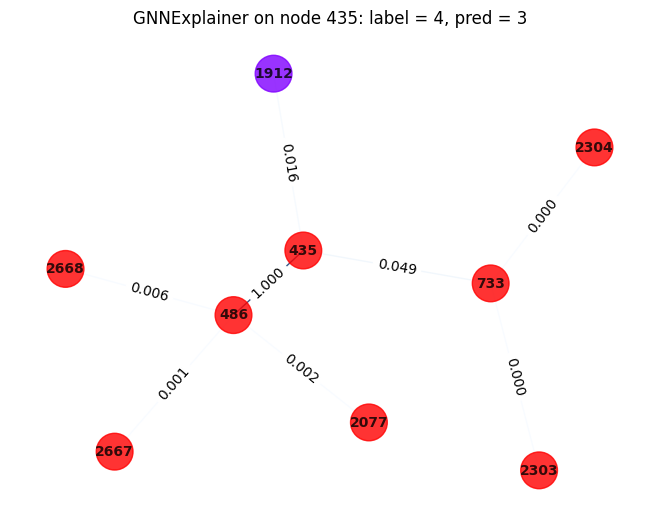

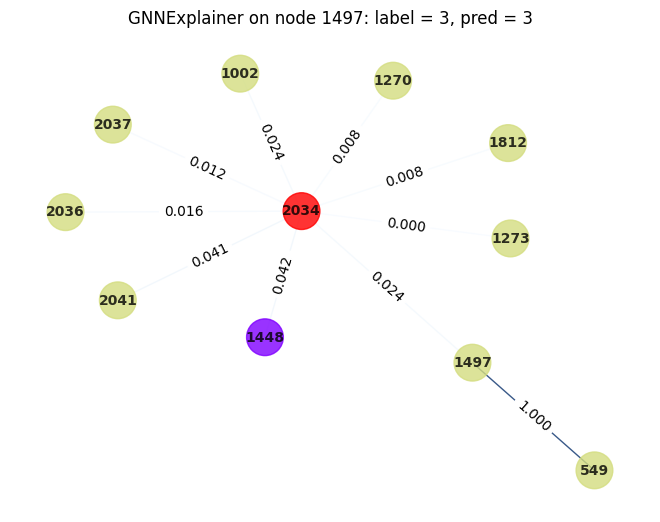

In [40]:
# This function creates a subgraph of the important edges (those with edge_mask above the threshold)
# and visualizes it using NetworkX, with nodes colored by their predicted class and edges colored
# based on their normalized importance.
def visualize_edge_weights_gnnexplainer(edge_mask, data, node_idx, preds, threshold=0.0, seed=42):
    labels = data.y
    edge_index = data.edge_index

    # Create the graph
    G = nx.Graph()
    for i, edge in enumerate(edge_index.T):
        if edge_mask[i] > threshold:
            G.add_edge(edge[0].item(), edge[1].item(), weight=edge_mask[i])
            G.add_node(edge[0].item(), pred=preds[edge[0].item()])
            G.add_node(edge[1].item(), pred=preds[edge[1].item()])

    # Normalize edge weights
    edges = G.edges(data=True)
    original_weights = [edge[2]['weight'].item() for edge in edges]
    min_val = min(original_weights)
    max_val = max(original_weights)
    normalized_weights = [(x - min_val) / (max_val - min_val) for x in original_weights]

    # Node colors based on predicted class
    node_colors = [int(G.nodes[n]['pred']) for n in G.nodes]

    # Layout for node positions
    pos = nx.spring_layout(G, seed=seed)
    nx.draw(
        G, pos,
        with_labels=True,
        node_size=700,
        node_color=node_colors,
        cmap=plt.get_cmap('rainbow'),
        font_size=10,
        font_weight='bold',
        edge_color=normalized_weights,
        edge_cmap=plt.cm.Blues,
        alpha=0.8
    )

    # Edge labels showing normalized weights
    edge_labels = {
        (u, v): f'{w:.3f}' for ((u, v, d), w) in zip(edges, normalized_weights)
    }

    nx.draw_networkx_edge_labels(
        G, pos,
        edge_labels=edge_labels,
        font_color='black'
    )

    # Display the title with the true and predicted labels for the node
    plt.title(f'GNNExplainer on node {node_idx}: label = {labels[node_idx]}, pred = {preds[node_idx]}')
    plt.show()

# Set up the explainer with configuration
max_neighbors = 10

explainer = Explainer(
    model=model,
    algorithm=GNNExplainer(epochs=200),
    explanation_type='model',
    node_mask_type=None,
    edge_mask_type='object',
    model_config=dict(
        mode='multiclass_classification',
        task_level='node',
        return_type='log_probs',
    ),
    threshold_config=dict(
        threshold_type='topk',
        value=max_neighbors,
    ),
)

# List of target nodes to analyze
target_nodes = [0, 1, 2, 6, 435, 1497]

# Ensure the model is in evaluation mode
model.eval()

# Get the predictions from the model
_, preds = model(data.x, data.edge_index).max(dim=1)

# Analyze and visualize each selected node
for node_idx in target_nodes:
    # Generate the explanation for the selected node
    explanation = explainer(data.x.to(device), data.edge_index.to(device), index=node_idx)
    edge_mask = explanation.edge_mask  # Get the edge mask for visualization

    # Visualize the explanation using the function
    visualize_edge_weights_gnnexplainer(edge_mask, data, node_idx, preds)